# peak detection in spikeinterface

Author : Samuel Garcia

spikeinterface implements several method for peak detection.

peak detection can be used:
  1. as a first step for spike sorting chain
  2. as a first step for estimating motion (aka drift)


Here we will illustrate how this work and also how in conjonction of the preprocessing module we can compute this detection **with or without caching** the preprocessed traces on the disk.


This example will be run on neuropixel 1 and neuropixel 2 recorded by Nick Steinmetz [here](https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495).





In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %matplotlib widget
%matplotlib inline

In [4]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si




### open dataset

In [23]:
# local folder
base_folder = Path('/mnt/data/sam/DataSpikeSorting/imposed_motion_nick')

dataset_folder = base_folder / 'dataset1/NP2'
preprocess_folder_bin = base_folder / 'dataset1_NP2_preprocessed_binary'
preprocess_folder_zarr = base_folder / 'dataset1_NP2_preprocessed_zarr'

In [21]:
# read the file
rec = si.read_spikeglx(dataset_folder)
rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1956.954s

(-150.0, 200.0)

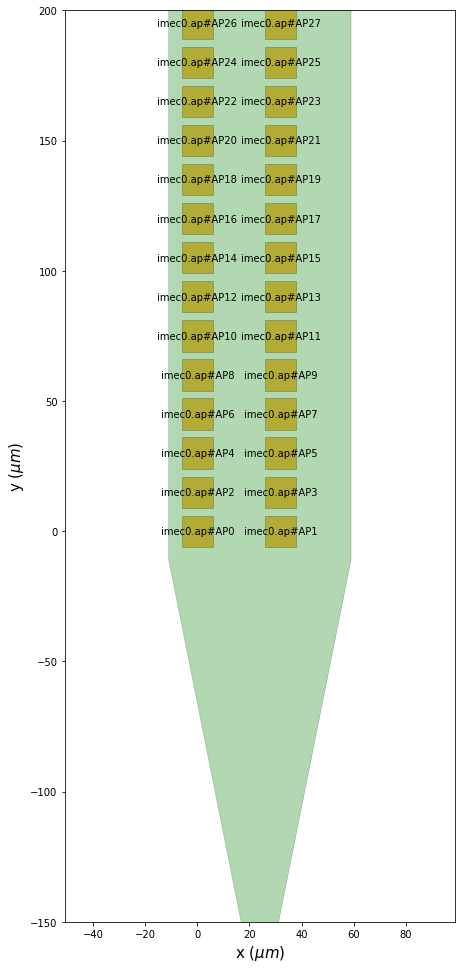

In [22]:
fig, ax = plt.subplots(figsize=(7, 20))
si.plot_probe_map(rec, with_channel_ids=True, ax=ax)
ax.set_ylim(-150, 200)

## preprocess

Here we will apply filetring + CMR

And to demonstrate the flexibility we will on work on 3 objects:
  * the lazy object `rec_preprocessed` 
  * the cached object in binary format `rec_preprocessed_cached_binary`
  * the cached object in zarr format `rec_preprocessed_cached_zarr`

Caching to **binary** take 
Caching to **zarr** take 

In [24]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=20,
    chunk_duration='1s',
    progress_bar=True,
)

In [27]:
# create the lazy object
rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
rec_preprocessed = si.common_reference(rec_filtered, reference='global', operator='median')
print(rec_preprocessed)


CommonReferenceRecording: 384 channels - 1 segments - 30.0kHz - 1956.954s


In [29]:
# if not exists yet cache to binary
if preprocess_folder_bin.exists():
    rec_preprocessed_cached_binary = si.load_extractor(preprocess_folder_bin)
else:
    # cache to binary
    rec_preprocessed_cached_binary = rec_preprocessed.save(folder=preprocess_folder_bin, format='binary', **job_kwargs)


write_binary_recording with n_jobs 40  chunk_size 30000


write_binary_recording: 100%|██████████| 1957/1957 [03:41<00:00,  8.85it/s]


In [30]:
print(rec_preprocessed_cached_binary)

BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1956.954s
  file_paths: ['/mnt/data/sam/DataSpikeSorting/imposed_motion_nick/dataset1_NP2_preprocessed_binary/traces_cached_seg0.raw']


In [32]:
if preprocess_folder_zarr.exists():
    rec_preprocessed_cached_zarr = si.load_extractor(preprocess_folder_zarr)
else:
    # cache to zarr
    rec_preprocessed_cached_zarr = rec_preprocessed.save(zarr_path=preprocess_folder_zarr,  format='zarr', **job_kwargs)

write_zarr_recording with n_jobs 40  chunk_size 30000


write_zarr_recording: 100%|██████████| 1957/1957 [03:37<00:00,  9.01it/s]


Skipping field contact_plane_axes: only 1D and 2D arrays can be serialized


In [33]:
print(rec_preprocessed_cached_zarr)

ZarrRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 1956.954s


### show some traces

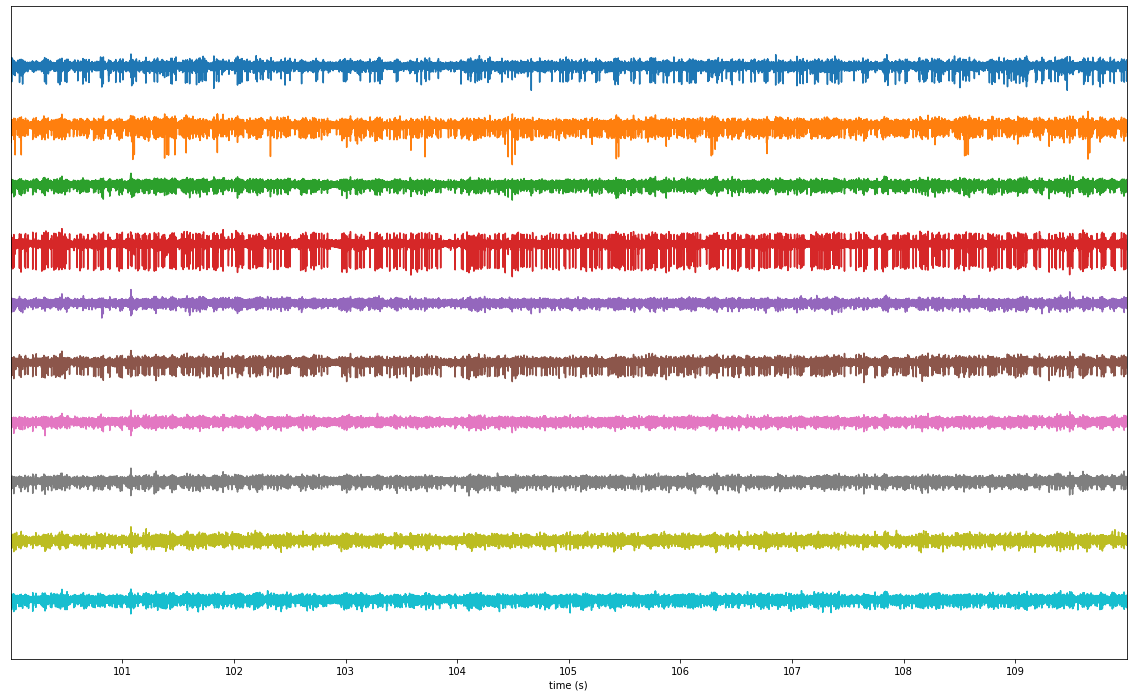

In [9]:
# plot and check spikes
si.plot_timeseries(rec_preprocessed, time_range=(100, 110), channel_ids=rec.channel_ids[50:60])

## estimate noise

We need some estimation of the noise.

Very important : we must estimate the noise with `return_scaled=False` because `detect_peaks()` will work on raw data (int16 very often)

Text(0.5, 1.0, 'noise across channel')

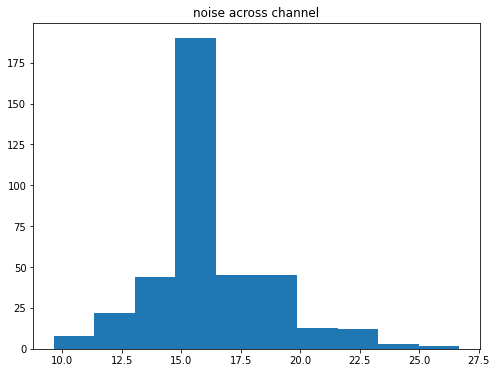

In [39]:
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(noise_levels, bins=10)
ax.set_title('noise across channel')

## detect peaks

we have 2 methods in spikeinetrface with are done with numba:

  * 'by_channel'  : peaks are detected on each channel indepandantly
  * 'locally_exclusive' : if a units fire on several channel the best peak on the best channel is kept
     This is controlle by `local_radius_um`


In [34]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

In [40]:
peaks = detect_peaks(rec_preprocessed,
                     method='locally_exclusive',
                     local_radius_um=100,
                     peak_sign='neg',
                     detect_threshold=5,
                     n_shifts=5,
                     noise_levels=noise_levels,
                    **job_kwargs)
print(peaks.shape)

detect peaks: 100%|██████████| 1957/1957 [02:09<00:00, 15.09it/s]


(2531770,)


## compare compute time with cached version

When we detect peak on the lazy object. Every trace chunk is loaded processed and then peak are detected on it.

When we detect peak on cached version the trace chunk is read from the save version

In [41]:
peaks = detect_peaks(rec_preprocessed_cached_binary,
                     method='locally_exclusive',
                     local_radius_um=100,
                     peak_sign='neg',
                     detect_threshold=5,
                     n_shifts=5,
                     noise_levels=noise_levels,
                    **job_kwargs)
print(peaks.shape)

detect peaks: 100%|██████████| 1957/1957 [01:30<00:00, 21.55it/s]


(2528737,)


In [42]:
peaks = detect_peaks(rec_preprocessed_cached_zarr,
                     method='locally_exclusive',
                     local_radius_um=100,
                     peak_sign='neg',
                     detect_threshold=5,
                     n_shifts=5,
                     noise_levels=noise_levels,
                    **job_kwargs)
print(peaks.shape)

detect peaks: 100%|██████████| 1957/1957 [01:28<00:00, 22.23it/s]


(2528737,)


## Conlusion

Running peak detection on lazy vs cached version is an important choice.

`detect_peak()` is a bit faster on cahed version (1:30) than lazy version (2:00)

But the total time of `save()` + `detect_peak()` is slower (3:00 + 1:30 = 4:30) !!!

Here writing to disk is clearly a waste on time.

So the benefit of caching totally depend:
 1. on the complexity of the preprocessing chain
 2. writting disk capability
 3. how many the preprocessed recording will be cunsumed!!!
